##### Copyright 2020 The TensorFlow Quantum Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# A Hybrid Quantum-Classical Optimization for Quantum Control Optimization


Now that the basics are understood, let's show how one might use TFQ to construct a **hybrid quantum-classical neural net** for quantum control. 


In the frist problem, we train a classical deep neural net to control a single qubit for realizing an arbitrary unitary; the output of the classical neural network determines the parameters of the quantum circuit to be applied to the qubit, which is then measured to produce the expectation values of different measurement operators.

In the second problem, we train a recurrent neural network, to learn to predict the future quantum dynamics based on past obervations of a noisy implementation of quantum circuit.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/control/control.ipynb)

## Installation and imports

In [0]:
!pip install --upgrade cirq==0.7.0

In [0]:
!pip install --upgrade tensorflow==2.1.0

In [0]:
!pip install tfq-nightly

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import cmath
import numpy as np
from scipy import linalg

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Problem 1: Gate decomposition with DNN.

### 1.1 Problem definition.

More specifically, we provide an example of training a classical neural network to learn the Bloch Theorem: any single qubit unitary transformation can be realized by three single qubit rotations around two different angles.


Given the specification of the single qubit unitary in regard to three parameters $\phi, \theta_1, \theta_2$ that specifies the block sphere as the input to the classical neural network: the neural network will output rotation angles along two different axis ( $Ry$, and $Rz$) that realizes the given rotation. If we include a penalty term on the number of non-zero rotations, the training of a classical neural network should be able to find the most optimal.

<img src="https://i.imgur.com/LX134rt.png" width="1000">

This idealized version of a real quantum control problem where a classical neural network is learning a physical law of optimal decomposition of single-qubit unitaries.

Up to a global phase, an arbitrary single-qubit unitary can be specified in terms of three angles $\phi$, $\theta_1$, and $\theta_2$ as $U=\exp(-i \phi (\cos(\theta_1)Z + \sin(\theta_1)(\cos(\theta_2)X + \sin(\theta_2)Y))$.

It is possible to realize an arbitrary unitary of this form using three rotations about only two axes, $U = R_z(\beta)R_y(\gamma)R_z(\delta)$.  There exists an analytic solution mapping $\{\phi, \theta_1, \theta_2\}$ to $\{\beta, \gamma, \delta\}$; however, for more sophisticated control problems, such an analytic mapping may not be available.  Therefore we investigate training neural networks to perform the control.  First we consider training a purely classical neural network to perform the mapping from unitary parameters to rotation angles.  Then, we consider training a hybrid quantum-classical network directly on expectation value data.

First, we define the map from $\{\phi, \theta_1, \theta_2\}$ to the associated unitary:

In [0]:
def get_unitary_from_params(phi, theta_1, theta_2):
  return linalg.expm(-1j*phi*(
      np.cos(theta_1)*cirq.Z._unitary_()
      + np.sin(theta_1)*(
          np.cos(theta_2)*cirq.X._unitary_()
          + np.sin(theta_2)*cirq.Y._unitary_()
      )
  ))

### 1.2 Physics model construction

#### Following lines are analytic solution to the Bloch theorem, where batch input is the input to a unitary parameterized by $U=\exp(-i \phi (cos(\theta_1)Z + \sin(\theta_1)(\cos(\theta_2)X + \sin(\theta_2)Y))$, the output is the angle $\beta, \gamma, \delta$ for the Z Y Z rotations that realizes the target unitary.

Next, we write down the known mapping between the angles $\{\phi, \theta_1, \theta_2\}$ and the two-axis control angles $\{\beta, \gamma, \delta\}$.

In [0]:
def map_unitary_params(phi, theta_1, theta_2):
  """Convert unitary angles into two-axis control angles."""
  #### Below works ONLY when all input angles are less than pi

  gamma = -2*np.arccos(-np.sqrt(3 + np.cos(2 * theta_1)  + 2 * np.sin(theta_1) ** 2 * np.cos(phi* 2) )/2.0)

  delta = 2*np.real(-  1j * np.log(-(-1.0) ** (1/4) *np.sqrt(- np.exp(1j * phi) * (-1 + np.exp(2 * 1j * phi))   * 
                                                              np.sqrt(3 + np.cos(2 * theta_1)  + 2 * np.sin(theta_1) ** 2 * np.cos(phi* 2) )) /
                                      2 / np.sqrt(-np.exp(1j * ( 2 *phi+ theta_2)) * np.sin(phi) ** 2 
                                                  * (np.cos(theta_1) + 1j / np.tan(phi))) ))

  beta = 2*np.real(-  1j * np.log(- np.exp(1j * ( phi+ theta_2)) * 
                                      np.sqrt(-1j * np.exp(1j * phi)*(-1 + np.exp(2 * 1j * phi))
                                      *np.sqrt(3 + np.cos(2 * theta_1)  + 2 * np.sin(theta_1) ** 2 * np.cos(phi* 2) ))
                                      * np.sin(phi)/(-1 + np.exp(2 * 1j * phi)) /
                                      np.sqrt(- np.exp(1j * (2 * phi+ theta_2)) * np.sin(phi) *( np.sin(phi) * np.cos(theta_1) + 1j * np.cos(phi) )) ))

  return beta, gamma, delta

Build a function to generate training data:

In [0]:
def get_angles_training_data(batch_size):
    data = []
    labels = []
    for _ in range(batch_size):
      random_unitary_params = np.random.uniform(0,  np.pi, (3)).tolist()
      beta, gamma, delta = map_unitary_params(*random_unitary_params)
      data.append(random_unitary_params)
      labels.append([beta, gamma, delta])
    return data, labels

Using this function, set up the training and validation data:

In [0]:
 

train_size = 10000
validation_size = 10000
all_commands, all_expectations = get_expectation_training_data(train_size + validation_size)

commands_train = all_commands[:train_size]
expectations_train = all_expectations[:train_size]
commands_val = all_commands[-validation_size:]
expectations_val = all_expectations[-validation_size:]

Run a test to confirm that all training data is correct.  We do this by checking the Hilbert-Schmidt inner product $\langle U_i, U_o\rangle = \text{Tr}\left(U_o^\dagger U_i\right)$ between the two resulting matrices:

In [0]:
for data_angles, label_angles in zip(commands_train, all_expectations):
  test_phi, test_theta_1, test_theta_2 = data_angles
  beta = label_angles[0]
  gamma = label_angles[1]
  delta = label_angles[2]
  u_i = get_unitary_from_params(test_phi, test_theta_1, test_theta_2)
  u_o = np.matmul(cirq.Rz(beta)._unitary_(),
      np.matmul(cirq.Ry(gamma)._unitary_(), cirq.Rz(delta)._unitary_()))
  
  circuit = cirq.Circuit(cirq.Rz(delta)(q), cirq.Ry(   gamma)(q), cirq.Rz(beta)(q))
 
  check1= np.trace(np.matmul(u_o.conj().T, circuit.unitary())) ** 2 / 4.0

  check = np.trace(np.matmul(u_o.conj().T, u_i))** 2 / 4.0
 

  if (abs(abs(check) - 1) > 1e-5) and (abs(abs(check1) - 1) > 1e-5):
    print("Inner product value:")
    print(check)
    print("Input angles quadrant check:")
    print([int(test_phi>np.pi), int(test_theta_1>np.pi), int(test_theta_2>np.pi)])

### 1.3 Prepare the training data set based on input and expectation values.

In [0]:
def get_expectation_training_data(batch_size):
    q = cirq.GridQubit(0, 0)
    beta_s, gamma_s, delta_s = sympy.symbols("beta gamma delta")
    circuit = cirq.Circuit(cirq.Rz(delta_s)(q), cirq.Ry(gamma_s)(q), cirq.Rz(beta_s)(q))
    ops = [cirq.X(q), cirq.Y(q), cirq.Z(q)]

    params = []
    outputs = []
    for _ in range(batch_size):
      random_unitary_params = np.random.uniform(0,  np.pi, (3)).tolist()
      beta, gamma, delta = map_unitary_params(*random_unitary_params)
      expectations = tfq.layers.Expectation()(
          circuit,
          symbol_names=[beta_s, gamma_s, delta_s],
          symbol_values=[[beta, gamma, delta]],
          operators=ops 
      ).numpy().tolist()[0]
      params.append(random_unitary_params)
      outputs.append(expectations)
    return params, outputs

We now define the hybrid network that will be trained to perform the qubit control.  Note that we restrict the gate set of the quantum portion of the net to alternating $R_z$ and $R_y$ gates.  By adding a term to the loss that induces sparsity on the controls of these gates, the hope is that the hybrid network will learn the optimal two-axis control (which requires only three angles).

### 1.4 Build a quantum-classical hybrid neural network to control the rotations.

In [0]:
def loss(y_true,y_pred ):
    return -tf.math.log(tf.reduce_mean(tf.square(y_pred - y_true), axis=-1)) #+ 0.1 * tf.reduce_sum(tf.square(tf.math.tanh(dense_3)), axis=-1)

circuits_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='circuits_input')
commands_input = tf.keras.Input((3,), name='commands_input')
dense_layer_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_layer_1')(commands_input)
dense_layer_2 = tf.keras.layers.Dense(128, name='dense_layer_2')(dense_layer_1)
dense_layer_3 = tf.keras.layers.Dense(64, activation='relu', name='dense_layer_3')(dense_layer_2) 
angles_layer = tf.keras.layers.Dense(3,  activation='linear', name='angles_layer')(dense_layer_3)

measured_expectations = tfq.layers.ControlledPQC(
    two_axis_control_circuit, measure_list)([circuits_input, angles_layer])
two_axis_control_model = tf.keras.Model(inputs=[circuits_input, commands_input], outputs=measured_expectations)

Set up data

In [0]:
train_size = 10000
validation_size = 10000
all_commands, all_expectations = get_expectation_training_data(train_size + validation_size)

commands_train = all_commands[:train_size]
expectations_train = all_expectations[:train_size]
commands_val = all_commands[-validation_size:]
expectations_val = all_expectations[-validation_size:]

Perform optimization

In [0]:
epochs = 200
batch_size = 1000
lr=0.010 

two_axis_control_model.compile(tf.keras.optimizers.Adam(learning_rate=lr, decay=lr / epochs), 
              loss='mse')
history_two_axis = two_axis_control_model.fit(
    x=[tfq.convert_to_tensor([cirq.Circuit()]*train_size), tf.convert_to_tensor(commands_train)],
    y=tf.convert_to_tensor(expectations_train), batch_size=batch_size, epochs=epochs,
    validation_data=(
        [tfq.convert_to_tensor([cirq.Circuit()]*validation_size), tf.convert_to_tensor(commands_val)],
                               tf.convert_to_tensor(expectations_val)))

Train on 10000 samples, validate on 10000 samples
Epoch 1/200
10000/10000 [==============================] - 3s 347us/sample - loss: 0.3856 - val_loss: 0.3154
Epoch 2/200
10000/10000 [==============================] - 3s 256us/sample - loss: 0.2913 - val_loss: 0.2889
Epoch 3/200
10000/10000 [==============================] - 3s 260us/sample - loss: 0.2715 - val_loss: 0.2741
Epoch 4/200
10000/10000 [==============================] - 3s 264us/sample - loss: 0.2600 - val_loss: 0.2636
Epoch 5/200
10000/10000 [==============================] - 3s 264us/sample - loss: 0.2463 - val_loss: 0.2428
Epoch 6/200
10000/10000 [==============================] - 3s 267us/sample - loss: 0.2178 - val_loss: 0.2018
Epoch 7/200
10000/10000 [==============================] - 3s 268us/sample - loss: 0.1782 - val_loss: 0.1624
Epoch 8/200
10000/10000 [==============================] - 3s 264us/sample - loss: 0.1456 - val_loss: 0.1490
Epoch 9/200
10000/10000 [==============================] - 3s 258us/sample - l

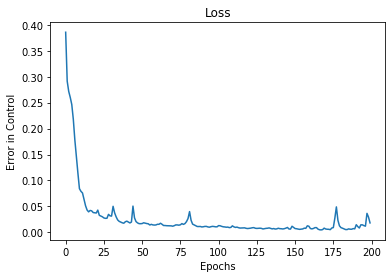

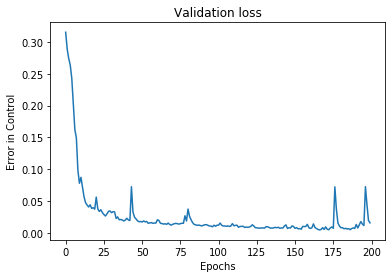

In [0]:
plt.plot(history_two_axis.history['loss'])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Error in Control")
plt.show()

plt.plot(history_two_axis.history['val_loss'])
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Error in Control")
plt.show()

## 2. LSTM for learning time-dependent quantum noise

## 2.0 Model definition.

In [0]:
def build_model(batch_size, rnn_units, stateful=False): 
  model = tf.keras.Sequential([
      tf.keras.layers.LSTM(
           rnn_units,
          return_sequences=True,
          stateful=stateful,
          recurrent_initializer='glorot_uniform',
          batch_input_shape=[batch_size, None, 1]),
      tf.keras.layers.Dense(1)
  ])
  return model 

def train_lstm(data, batch_size, rnn_units, epochs, learning_rate):
  print('Start training.')
  model = build_model(batch_size, rnn_units)

  def loss(labels, logits):
    return tf.keras.losses.binary_crossentropy(labels, logits, True)

 
  optimizer = tf.keras.optimizers.Adamax( learning_rate) 
  model.compile(optimizer=optimizer, loss=loss)
  model.summary()
 
 
  model.fit(data, epochs= epochs)
  eval_loss = model.evaluate(data)
  print( "final loss = ", eval_loss)
  return model


def sample_eval(weights,  eval_samples, epoch, rnn_units, input_lenth):
  model = build_model( batch_size, rnn_units, True)
  model.build(tf.TensorShape([ batch_size, None, 1]))
  model.set_weights(weights)
  # Whole sequence sampling and fidelity
  eval_samples = eval_samples //  batch_size *  batch_size
  sample_data = np.zeros(((eval_samples,  input_length)), np.float64)
  sample_n = 0
  model.summary()

  while sample_n < eval_samples:
    model.reset_states()
    input_eval = tf.zeros([ batch_size, 1, 1])
    output_eval = tf.reshape(model(input_eval), [ batch_size])
    output_prob = 1 / (1 + np.exp(-output_eval.numpy()))
    sample_data[sample_n:sample_n +  batch_size,
                0] =output_prob
    for i in range( input_length - 1):
      input_eval = tf.cast(
          tf.reshape(sample_data[sample_n:sample_n +  batch_size, i],
                     [ batch_size, 1, 1]), tf.float32)
      output_eval = tf.reshape(model(input_eval), [ batch_size])
      output_prob = 1 / (1 + np.exp(-output_eval.numpy()))
      sample_data[sample_n:sample_n +  batch_size,
                  i + 1] = np.random.binomial(1, output_prob)
    sample_n +=  batch_size
 


def generate_data(data_time, data_length, omega_0, exponent, alpha):

  timesteps = np.linspace(0.02, data_time, data_length)
  q = cirq.GridQubit(0, 0)
  phase_s = sympy.symbols("phaseshift")
  circuit = cirq.Circuit(cirq.H(q), cirq.Rz(phase_s)(q))
  ops = [cirq.X(q)]

  params = []
  outputs = np.zeros(data_length)

  for i in range(data_length):
    phaseshift = timesteps[i] * omega_0 + alpha * timesteps[i] ** (exponent +1) / (exponent +1)
    expectations = tfq.layers.Expectation()(
        circuit,
        symbol_names=[phase_s],
        symbol_values=[[phaseshift]],
        operators=ops 
    ).numpy().tolist()[0]
     
    outputs[i]= expectations[0] 
  return outputs
     
def load_data(data_size, data_time, data_length, alpha_min, alpha_max, omega_0, exponent):
  alpha_list = np.linspace(alpha_min, alpha_max, data_size)
  train_data = []
  for k in range(data_size):
    data1 = generate_data(data_time, data_length, omega_0, exponent, alpha_list[k])
    train_data.append(data1)
  return np.array(train_data)

   
 

### 2.1 Generate training data

In [0]:
epoch = 30
batch_size = 60
learning_rate = 0.001

rnn_units = 256
data_size = 500
alpha_min = 0.031
alpha_max = 0.2
exponent = 0.5
omega_0 = 0.7 
data_time = 0.5 / alpha_min
data_length = 40
 

train_data = load_data(data_size, data_time, data_length, alpha_min, alpha_max, omega_0, exponent)  # this should be a numpy array

## 2.2 Training the LSTM model on the time-dependent expectation values.

In [0]:
data = tf.data.Dataset.from_tensor_slices(train_data)

def build_example(chunk):
  input_seq = tf.cast(tf.concat([[0], chunk], 0), tf.float32)
  target = tf.concat([chunk, [0]], 0)
  input_seq = input_seq[:-1]
  target = target[:-1]
  return tf.expand_dims(input_seq, 1), tf.expand_dims(target, 1)
BUFFER_SIZE = 100
data = data.map(build_example).shuffle(BUFFER_SIZE).batch(
    batch_size, drop_remainder=True)

In [0]:
model = train_lstm(data, batch_size, rnn_units, epoch, learning_rate)

Start training.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (60, None, 256)           264192    
_________________________________________________________________
dense (Dense)                (60, None, 1)             257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Train for 8 steps
Epoch 1/30
8/8 [==============================] - 3s 322ms/step - loss: 0.6305
Epoch 2/30
8/8 [==============================] - 1s 159ms/step - loss: 0.2761
Epoch 3/30
8/8 [==============================] - 1s 156ms/step - loss: 0.1193
Epoch 4/30
8/8 [==============================] - 1s 153ms/step - loss: 0.0911
Epoch 5/30
8/8 [==============================] - 1s 153ms/step - loss: 0.0797
Epoch 6/30
8/8 [==============================] - 1s 155ms/step - loss: 0.0733
Epoc

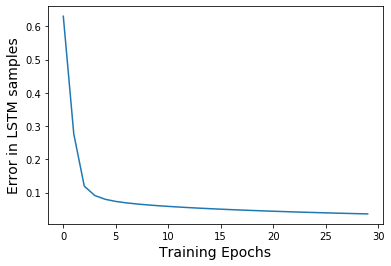

In [0]:
plt.plot(model.history.history['loss']) 
plt.xlabel("Training Epochs", fontsize='14')
plt.ylabel("Error in LSTM samples", fontsize='14')
plt.show()